<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/main/help/notebooks/prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/main/help/notebooks/prediction.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

# Install HELP from GitHub
Skip this cell if you already have installed HELP.

In [ ]:
!pip install git+https://github.com/giordamaug/HELP.git

# Download the input files
In this cell we download from GitHub repository the label file and the attribute files. Skip this step if you already have these input files locally.

In [ ]:
tissue='Kidney'
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/help/datafinal/{tissue}_HELP.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/help/datafinal/{tissue}_BIO.csv
for i in range(5):
  !wget https://raw.githubusercontent.com/giordamaug/HELP/main/help/datafinal/{tissue}_CCcfs_{i}.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/help/datafinal/{tissue}_EmbN2V_128.csv

In [6]:
%cd ../../data

/Users/maurizio/HELP/data


# Process the tissue attributes
In this code we load tissue gene attributes by several datafiles. We apply missing values fixing and data scaling with `sklearn.preprocessing.StandardScaler` on the `BIO` and `CCcfs` attributes, while no normalization and fixing on embedding attributes (`EmbN2V_128`). The attributes are all merged in one matrix by the `feature_assemble` function as input for the prediction model building.

In [19]:
%cd ../../data 
tissue='Lung'
import pandas as pd
from HELPpy.preprocess.loaders import feature_assemble_df
import os
df_y = pd.read_csv(f"{tissue}_HELP.csv", index_col=0)
df_y = df_y.replace({'aE': 'NE', 'sNE': 'NE'})
print(df_y.value_counts(normalize=False))
features = [{'fname': f'{tissue}_BIO.csv', 'fixna' : False, 'normalize': 'std'},
            {'fname': f'{tissue}_CCcfs.csv', 'fixna' : False, 'normalize': 'std', 'nchunks' : 5},
            {'fname': f'{tissue}_EmbN2V_128.csv', 'fixna' : False, 'normalize': None}]
df_X, df_y = feature_assemble_df(df_y, features=features, saveflag=False, verbose=True)

[Errno 2] No such file or directory: '../../data'
/Users/maurizio/HELP/data
label
NE       16696
E         1235
Name: count, dtype: int64
Majority NE 16696 minority E 1235
[Lung_BIO.csv] found 52507 Nan...
[Lung_BIO.csv] Normalization with std ...


Loading file in chunks: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


[Lung_CCcfs.csv] found 6749288 Nan...
[Lung_CCcfs.csv] Normalization with std ...
[Lung_EmbN2V_128.csv] found 0 Nan...
[Lung_EmbN2V_128.csv] No normalization...
17234 labeled genes over a total of 17931
(17234, 3455) data input


In [20]:
from HELPpy.models.prediction import VotingSplitClassifier, k_fold_cv
clf = VotingSplitClassifier(n_voters=10, n_jobs=-1, random_state=-1)
df_scores, scores, predictions = k_fold_cv(df_X, df_y, clf, n_splits=5, seed=0, verbose=True)
df_scores

{'E': 0, 'NE': 1}
label
NE       16010
E         1224
Name: count, dtype: int64
Classification with VotingSplitClassifier...


5-fold: 100%|██████████| 5/5 [01:15<00:00, 15.08s/it]


,measure
ROC-AUC,0.9584±0.0043
Accuracy,0.8848±0.0025
BA,0.8939±0.0070
Sensitivity,0.9044±0.0156
Specificity,0.8833±0.0031
MCC,0.5354±0.0079
CM,"[[1107, 117], [1868, 14142]]"


In [20]:
scores

,ROC-AUC,Accuracy,BA,Sensitivity,Specificity,MCC,CM
0,0.954258,0.878735,0.889496,0.902041,0.876952,0.522809,"[[221, 24], [394, 2808]]"
1,0.953289,0.873223,0.894068,0.918367,0.869769,0.520189,"[[225, 20], [417, 2785]]"
2,0.955901,0.884827,0.890891,0.897959,0.883823,0.532617,"[[220, 25], [372, 2830]]"
3,0.960578,0.882507,0.895296,0.910204,0.880387,0.533671,"[[223, 22], [383, 2819]]"
4,0.965238,0.880731,0.901747,0.926230,0.877264,0.536883,"[[226, 18], [393, 2809]]"


In [21]:
predictions

,label,prediction,probabilities
gene,,,
A2M,1,1,0.016435
A2ML1,1,1,0.001649
AAGAB,1,1,0.230005
AANAT,1,1,0.002823
AARS2,1,0,0.529173
...,...,...,...
ZSCAN9,1,1,0.004752
ZSWIM6,1,1,0.007049
ZUP1,1,0,0.532555


In [21]:
predictions.to_csv(f"csEGs_{tissue}_spl_EvsNE.csv", index=True)

## Compute TPR for ucsEGs and csEGs

ucsEG Kidney TPR = 0.780 (46/59) ucsEG Kidney TPR =  0.897 (1114/1242)
ucsEG Lung TPR = 0.714 (20/28) ucsEG Lung TPR =  0.904 (1107/1224)


/var/folders/gl/gkr8rrn52y9cvb9jc59pvjyw0000gn/T/ipykernel_14958/2539520865.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = data, y = labels, ax=ax, palette = sns.color_palette("pastel"))
/var/folders/gl/gkr8rrn52y9cvb9jc59pvjyw0000gn/T/ipykernel_14958/2539520865.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x = data, y = labels, ax=ax, palette = sns.color_palette("pastel"))


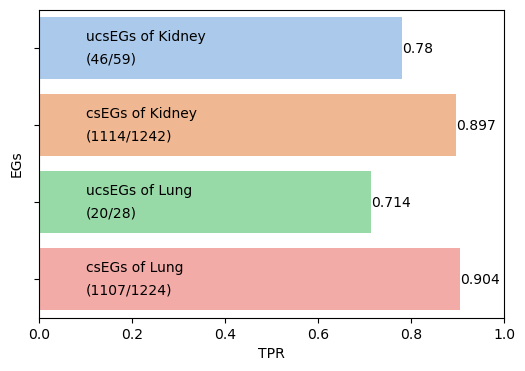

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
labels = []
data = []
tpr = []
for tissue in ['Kidney', 'Lung']:
    ucsEGs = pd.read_csv(f"ucsEG_{tissue}.txt", index_col=0, header=None).index.values
    predictions = pd.read_csv(f"csEGs_{tissue}_spl_EvsNE.csv", index_col=0)
    indices = np.intersect1d(ucsEGs, predictions.index.values)
    preds = predictions.loc[indices]
    num1 = len(preds[preds['label'] == preds['prediction']])
    den1 = len(preds[preds['label'] == 0])
    den2 = len(predictions[predictions['label'] == 0])
    num2 = len(predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])])
    labels += [f"ucsEGs of {tissue}", f"csEGs of {tissue}"]
    data += [float(f"{num1 /den1:.3f}"), float(f"{num2 /den2:.3f}")]
    tpr += [f"{num1}/{den1}", f"{num2}/{den2}"]
    print(f"ucsEG {tissue} TPR = {num1 /den1:.3f} ({num1}/{den1}) ucsEG {tissue} TPR =  {num2/den2:.3f} ({num2}/{den2})")

f, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x = data, y = labels, ax=ax, palette = sns.color_palette("pastel"))
ax.set_xlim(0,1)
ax.set_xlabel('TPR')
ax.set_ylabel('EGs')
ax.set(yticklabels=[])
for i,l,t in zip(range(4),labels,tpr):
    ax.text(0.1, i * 1.0 -0.1, l)
    ax.text(0.1, (i * 1.0 -0.1) + 0.3, f"({t})")
for i in ax.containers:
    ax.bar_label(i,)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = ['csEGs of kidney', 'csEGs of lung', 'cEGs (kidney)', 'cEGs (lung)']
tpr = ['46/59', '19/28', '1057/1158', '1060/1158']
data = [0.780, 0.679, 0.913, 0.915]
f, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x = data, y = labels, ax=ax, palette = sns.color_palette("pastel"))
ax.set_xlim(0,1)
ax.set_xlabel('TPR')
ax.set_ylabel('csEGs of tissue (model) / CEG (model)')
ax.set(yticklabels=[])
for i,l,t in zip(range(4),labels,tpr):
    ax.text(0.3, i * 1.0, l)
    ax.text(0.3, (i * 1.0) + 0.3, f"({t})")
for i in ax.containers:
    ax.bar_label(i,)